# Preprocessing, Baseline, and Initial Models #

In [390]:
import numpy as np
np.random.seed(123)
import tensorflow as tf
tf.random.set_seed(123)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt

## Normal vs Pneumonia X-rays ##

In [391]:
# Directory Paths
train_normal = 'CellData/chest_xray/train/NORMAL'
train_sick = 'CellData/chest_xray/train/PNEUMONIA'
test_normal = 'CellData/chest_xray/test/NORMAL'
test_sick = 'CellData/chest_xray/test/PNEUMONIA'

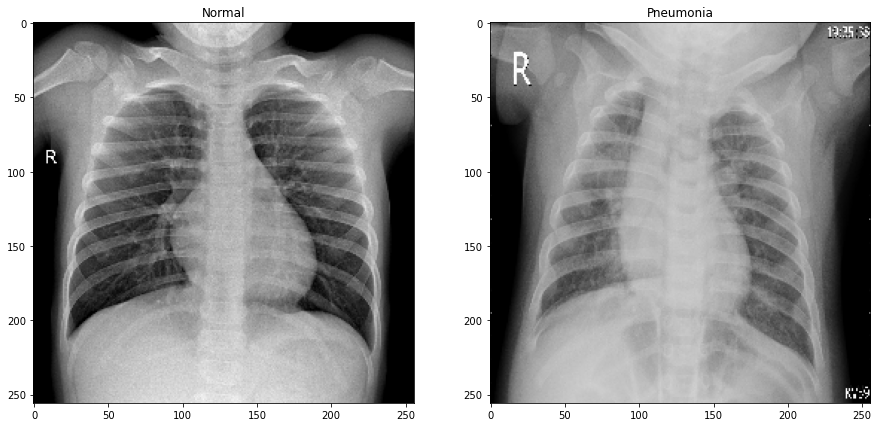

In [392]:
# Loading image:
fig, ax = plt.subplots(nrows = 1, ncols=2,figsize=(15,15))
img1 = load_img(f'{train_normal}/NORMAL-28501-0001.jpeg', target_size=(256,256))
ax[0].imshow(img1)
ax[0].set_title('Normal');
img2 = load_img(f'{train_sick}/BACTERIA-52163-0002.jpeg', target_size=(256,256))
ax[1].imshow(img2)
ax[1].set_title('Pneumonia');

From the above, we can see that lungs with pneumonia are more opaque. In lungs with pneumonia, the air sacs may fill with fluid or puss. Healthy lungs appear more clearly on the x-ray.

## Creating the Dataset ##

We'll begin modeling by only using a portion of our training data and all of the test data.

In [393]:
# Directory path
train_data_dir = 'CellData/chest_xray/train'
test_data_dir = 'CellData/chest_xray/test'

# Get all the data in the directory data/validation (624 images), and reshape them
test_generator = ImageDataGenerator().flow_from_directory(
        test_data_dir, 
        target_size=(256, 256), batch_size=624)

# Get all the data in the directory data/train (2496 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=2496)

# Create the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)

Found 624 images belonging to 2 classes.
Found 5232 images belonging to 2 classes.


In [394]:
# shape of train/test imges/labes
print(np.shape(train_images))
print(np.shape(train_labels))
print(np.shape(test_images))
print(np.shape(test_labels))

(2496, 256, 256, 3)
(2496, 2)
(624, 256, 256, 3)
(624, 2)


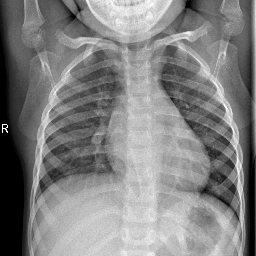

In [395]:
# check to see if images loaded correctly
array_to_img(train_images[132])

In [396]:
# label for this image
train_labels[132]

array([1., 0.], dtype=float32)

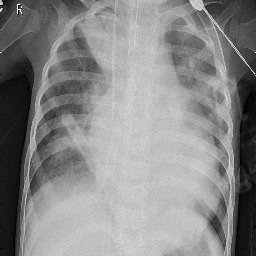

In [397]:
array_to_img(train_images[355])

In [398]:
train_labels[355]

array([0., 1.], dtype=float32)

In [400]:
# check the values for each class
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

## Baseline Model ##

### Fixing the labels ###

In [59]:
# fix the labels for the images so that normal=0 and pneumonia=1
y_model = train_labels.T[[1]]
y_test = test_labels.T[[1]]

In [60]:
# counts for each class
print('Train Class Counts:', np.unique(y_model, return_counts=True))
print('Test Class Counts:', np.unique(y_test, return_counts=True))

Train Class Counts: (array([0., 1.], dtype=float32), array([ 650, 1846]))
Test Class Counts: (array([0., 1.], dtype=float32), array([234, 390]))


We can see that there is a big class imbalance for the 'model' data. About 74% of the data belong to the pneumonia class. This will be an issue we must fix later on.

In [61]:
# reshape to make for putting into models
y_model = y_model.T
y_test = y_test.T
print(y_model.shape)
print(y_test.shape)

(2496, 1)
(624, 1)


### Creating the baseline model ###

Because there is such a big class imbalance, we can check to see how well a baseline model that only predicts the dominant, positive class performs.

In [62]:
# create a baseline model that predicts the dominant class
def baseline_model(train, test):
    elements_unique, elements_counts  = np.unique(train, return_counts=True)
    count_dict={}
    for i in range(len(elements_unique)):
        count_dict.update({elements_counts[i]:elements_unique[i]})
    prediction = max(elements_counts)
    predicted = [count_dict[prediction] for i in range(len(test))]
    return predicted

In [64]:
# Check the accuracy and recall on the test set for our baseline model
from sklearn import metrics

print('Test Accuracy:', metrics.accuracy_score(y_test, baseline_model(y_model, y_test)))
print('Test Recall:', metrics.recall_score(y_test, baseline_model(y_model, y_test)))

Test Accuracy: 0.625
Test Recall: 1.0


By just predicting the dominant, positive  class, our test accuracy is 62.5% and our recall is 100%, since we are not predicting the negative class at all. For our future models we will try to improve accuracy while maintain recall as close to one as possible.  

## Preprocessing ##

### Reshape and standardize images###

In [406]:
# reshape the images
train_img_unrow = train_images.reshape(2496, -1)
test_img_unrow = test_images.reshape(624, -1)

In [407]:
# standardize data
X_model = train_img_unrow/255
X_test = test_img_unrow/255

In [408]:
X_model.shape

(2496, 196608)

## Building the model ##

In [412]:
# split model set into training and validation set
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_model, y_model, test_size=0.2, random_state=765)

### Model 1 ###

In [413]:
# function for visualizing loss, accuracy, recall across epochs for training and validation set
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_recall'])
    plt.plot(history['recall'])
    plt.legend(['val_recall', 'recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

In [414]:
# create first NN with 3 hidden layers and tanh activation
model_1 = Sequential()
model_1.add(layers.Dense(128, activation='tanh', input_shape=(196608,)))
model_1.add(layers.Dense(64, activation='tanh'))
model_1.add(layers.Dense(32, activation='tanh'))
model_1.add(layers.Dense(1, activation='sigmoid'))

In [415]:
model_1.compile(loss='binary_crossentropy', 
                optimizer='sgd', 
                metrics=['accuracy', keras.metrics.Recall(name='recall')])

In [416]:
results_1 = model_1.fit(X_train, y_train, 
                        epochs=10, 
                        batch_size=64, 
                        validation_data=(X_val, y_val))

Epoch 1/10
32/32 [==============================] - 11s 350ms/step - loss: 0.7396 - accuracy: 0.6112 - recall: 0.7392 - val_loss: 0.5816 - val_accuracy: 0.7320 - val_recall: 1.0000
Epoch 2/10
32/32 [==============================] - 7s 204ms/step - loss: 0.5597 - accuracy: 0.7415 - recall: 1.0000 - val_loss: 0.5516 - val_accuracy: 0.7320 - val_recall: 1.0000
Epoch 3/10
32/32 [==============================] - 6s 192ms/step - loss: 0.5498 - accuracy: 0.7415 - recall: 1.0000 - val_loss: 0.5511 - val_accuracy: 0.7320 - val_recall: 1.0000
Epoch 4/10
32/32 [==============================] - 7s 204ms/step - loss: 0.5333 - accuracy: 0.7415 - recall: 1.0000 - val_loss: 0.5282 - val_accuracy: 0.7320 - val_recall: 1.0000
Epoch 5/10
32/32 [==============================] - 6s 199ms/step - loss: 0.5154 - accuracy: 0.7415 - recall: 1.0000 - val_loss: 0.6657 - val_accuracy: 0.7320 - val_recall: 1.0000
Epoch 6/10
32/32 [==============================] - 6s 190ms/step - loss: 0.5268 - accuracy: 0.7415

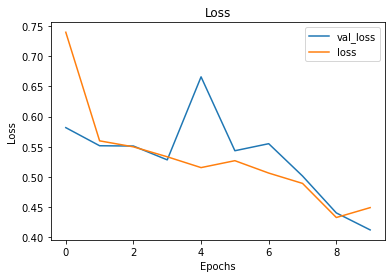

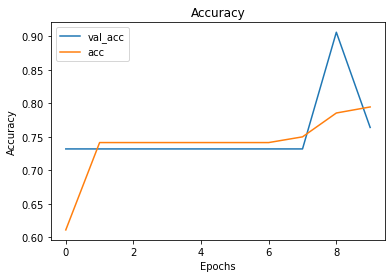

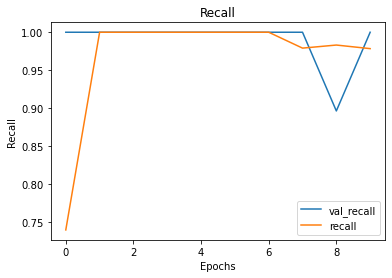

In [417]:
# change in loss and accuracy for training and validation set per epoch
visualize_training_results(results_1)

In [418]:
# evaluate training and test sets
results_train = model_1.evaluate(X_train, y_train)
results_test = model_1.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 2s 81ms/step - loss: 0.5693 - accuracy: 0.6314 - recall: 1.0000
[0.40649598836898804, 0.7700400948524475, 0.9993243217468262] [0.5693361759185791, 0.6314102411270142, 1.0]


This model is very overfit. The training accuracy is 0.77 while the test accuracy is .63. However, the recall is goof across both. Interestly, the recall is perfect on the test set. Could this be because of the high class imbalance? The model is not predicting false negatives. Is it just predicting the dominant class (positive, pneumonia)? It performs nearly identical to the baseline model.

### Model 2 ###

In [419]:
# create second model with same amount of hidden layers but with relu activation
model_2 = Sequential()
model_2.add(layers.Dense(128, activation='relu', input_shape=(196608,)))
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(1, activation='sigmoid'))

In [420]:
model_2.compile(loss='binary_crossentropy', 
                optimizer='sgd', 
                metrics=['accuracy', keras.metrics.Recall(name='recall')])

In [422]:
results_2 = model_2.fit(X_train, y_train, 
                        epochs=10, 
                        batch_size=64, 
                        validation_data=(X_val, y_val))

Epoch 1/10
32/32 [==============================] - 7s 234ms/step - loss: 0.3314 - accuracy: 0.8768 - recall: 0.9520 - val_loss: 0.2823 - val_accuracy: 0.9160 - val_recall: 0.9945
Epoch 2/10
32/32 [==============================] - 6s 196ms/step - loss: 0.3262 - accuracy: 0.8742 - recall: 0.9459 - val_loss: 0.4013 - val_accuracy: 0.8660 - val_recall: 0.8251
Epoch 3/10
32/32 [==============================] - 6s 195ms/step - loss: 0.3475 - accuracy: 0.8587 - recall: 0.9047 - val_loss: 0.3996 - val_accuracy: 0.8320 - val_recall: 1.0000
Epoch 4/10
32/32 [==============================] - 6s 188ms/step - loss: 0.3005 - accuracy: 0.8993 - recall: 0.9473 - val_loss: 0.2616 - val_accuracy: 0.9340 - val_recall: 0.9973
Epoch 5/10
32/32 [==============================] - 7s 216ms/step - loss: 0.3039 - accuracy: 0.8963 - recall: 0.9412 - val_loss: 0.3649 - val_accuracy: 0.8780 - val_recall: 0.8415
Epoch 6/10
32/32 [==============================] - 7s 219ms/step - loss: 0.2672 - accuracy: 0.9173 

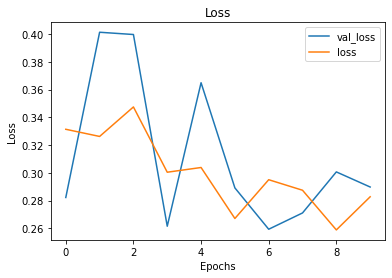

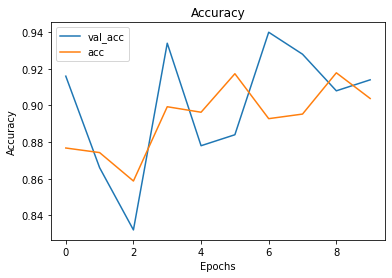

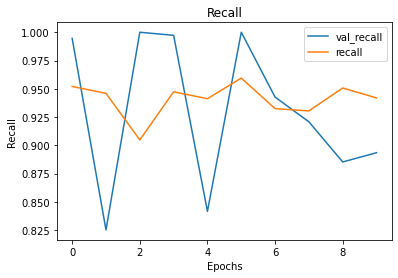

In [423]:
visualize_training_results(results_2)

In [424]:
results_train = model_2.evaluate(X_train, y_train)
results_test = model_2.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 1s 58ms/step - loss: 0.4062 - accuracy: 0.8654 - recall: 0.8923
[0.2946476340293884, 0.913827657699585, 0.8932432532310486] [0.4062180519104004, 0.8653846383094788, 0.892307698726654]


This model is less overfit than the first one. Accuracy on training set is .91 while the test set is .86. The recall went down on both of the sets. But are roughly the same.

### Model 3 ###

In [425]:
# new model with 5 hidden layers and relu activation for each of them
model_3 = Sequential()
model_3.add(layers.Dense(256, activation='relu', input_shape=(196608,)))
model_3.add(layers.Dense(128, activation='relu'))
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dense(32, activation='relu'))
model_3.add(layers.Dense(16, activation='relu'))
model_3.add(layers.Dense(1, activation='sigmoid'))

In [426]:
model_3.compile(loss='binary_crossentropy', 
                optimizer='sgd', 
                metrics=['accuracy', keras.metrics.Recall(name='recall')])

In [427]:
results_3 = model_3.fit(X_train, y_train, 
                        epochs=10, 
                        batch_size=64, 
                        validation_data=(X_val, y_val))

Epoch 1/10
32/32 [==============================] - 14s 424ms/step - loss: 0.6476 - accuracy: 0.7104 - recall: 0.9331 - val_loss: 0.5952 - val_accuracy: 0.7320 - val_recall: 1.0000
Epoch 2/10
32/32 [==============================] - 11s 332ms/step - loss: 0.5459 - accuracy: 0.7415 - recall: 1.0000 - val_loss: 0.5141 - val_accuracy: 0.7320 - val_recall: 1.0000
Epoch 3/10
32/32 [==============================] - 11s 342ms/step - loss: 0.5066 - accuracy: 0.7580 - recall: 0.9905 - val_loss: 0.7075 - val_accuracy: 0.7320 - val_recall: 1.0000
Epoch 4/10
32/32 [==============================] - 10s 309ms/step - loss: 0.4658 - accuracy: 0.7725 - recall: 0.9568 - val_loss: 0.3559 - val_accuracy: 0.8480 - val_recall: 1.0000
Epoch 5/10
32/32 [==============================] - 9s 294ms/step - loss: 0.4658 - accuracy: 0.7871 - recall: 0.9250 - val_loss: 0.6797 - val_accuracy: 0.4980 - val_recall: 0.3142
Epoch 6/10
32/32 [==============================] - 9s 291ms/step - loss: 0.3891 - accuracy: 0.8

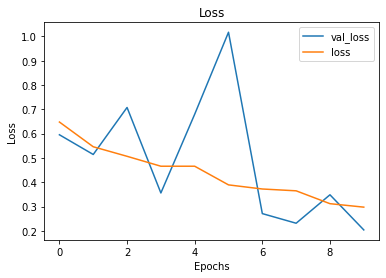

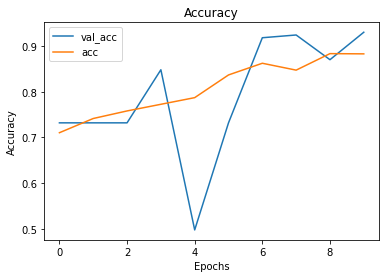

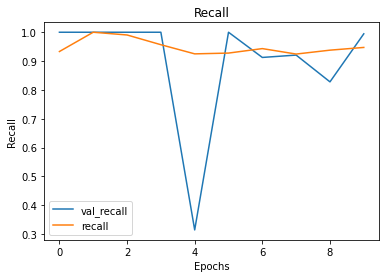

In [428]:
visualize_training_results(results_3)

In [429]:
results_train = model_3.evaluate(X_train, y_train)
results_test = model_3.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 2s 87ms/step - loss: 0.3870 - accuracy: 0.8173 - recall: 0.9872
[0.21074961125850677, 0.9283567070960999, 0.9783783555030823] [0.38696181774139404, 0.817307710647583, 0.9871794581413269]


This model overfit more than the last. In terms of accuracy, it performed much better on the training set. This means it's overfit. The recall was better on this one than the second and the accuracy was better than the first. Perhaps running the second and third model on the entire data set will improve performance.

## Train Models on Complete Dataset ##

### Create New Dataset ###

In [430]:
# Get all the data in the directory data/train, scale and reshape them
train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_data_dir, 
        target_size=(256, 256), batch_size=5232)

# Create the datasets
train_images_2, train_labels_2 = next(train_generator)

Found 5232 images belonging to 2 classes.


In [431]:
# fix the train labels and reshape
y_model_2 = train_labels_2.T[[1]]
y_model_2 = y_model_2.T

In [432]:
print('Train Class Counts:', np.unique(y_model_2, return_counts=True))
print('Test Class Counts:', np.unique(y_test, return_counts=True))

Train Class Counts: (array([0., 1.], dtype=float32), array([1349, 3883]))
Test Class Counts: (array([0., 1.], dtype=float32), array([234, 390]))


In [433]:
y_model_2.shape

(5232, 1)

In [434]:
# reshape the images
X_model_2 = train_images_2.reshape(5232, -1)

In [435]:
X_model_2.shape

(5232, 196608)

In [437]:
# split the train data further to have a validation set
X_train_2, X_val_2, y_train_2, y_val_2 = train_test_split(X_model_2, y_model_2, test_size=0.2, random_state=765)

### Model 4 (Model 2, but on entire dataset)

In [438]:
model_4 = Sequential()
model_4.add(layers.Dense(128, activation='relu', input_shape=(196608,)))
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dense(32, activation='relu'))
model_4.add(layers.Dense(1, activation='sigmoid'))

In [439]:
model_4.compile(loss='binary_crossentropy', 
                optimizer='sgd',
                metrics=['accuracy', keras.metrics.Recall(name='recall')])

In [440]:
results_4= model_4.fit(X_train_2, y_train_2,
                       epochs=10,
                       batch_size=64,
                       validation_data=(X_val_2, y_val_2))

Epoch 1/10
66/66 [==============================] - 20s 306ms/step - loss: 0.7209 - accuracy: 0.7168 - recall: 0.9298 - val_loss: 0.5449 - val_accuracy: 0.7307 - val_recall: 1.0000
Epoch 2/10
66/66 [==============================] - 19s 282ms/step - loss: 0.4784 - accuracy: 0.7859 - recall: 0.9724 - val_loss: 0.9543 - val_accuracy: 0.2808 - val_recall: 0.0157
Epoch 3/10
66/66 [==============================] - 18s 272ms/step - loss: 0.4273 - accuracy: 0.8146 - recall: 0.9134 - val_loss: 0.5984 - val_accuracy: 0.6533 - val_recall: 0.5281
Epoch 4/10
66/66 [==============================] - 17s 265ms/step - loss: 0.3530 - accuracy: 0.8542 - recall: 0.9250 - val_loss: 0.2508 - val_accuracy: 0.9198 - val_recall: 0.9660
Epoch 5/10
66/66 [==============================] - 16s 241ms/step - loss: 0.3106 - accuracy: 0.8703 - recall: 0.9355 - val_loss: 0.3945 - val_accuracy: 0.8243 - val_recall: 0.7673
Epoch 6/10
66/66 [==============================] - 13s 199ms/step - loss: 0.2739 - accuracy: 0

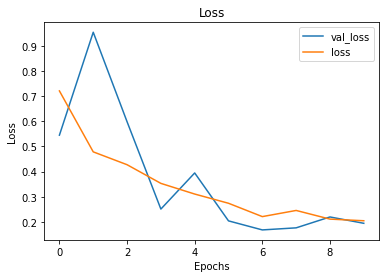

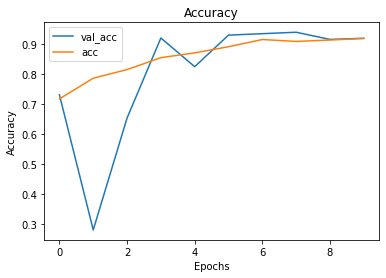

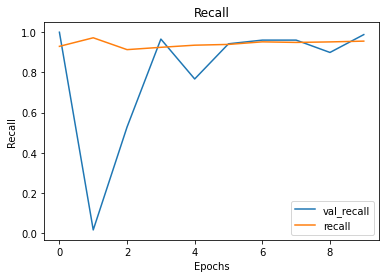

In [441]:
visualize_training_results(results_4)

In [442]:
results_train = model_4.evaluate(X_train, y_train)
results_test = model_4.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 2s 75ms/step - loss: 0.5795 - accuracy: 0.7660 - recall: 0.9923
[0.18694673478603363, 0.9233466982841492, 0.9898648858070374] [0.5795254111289978, 0.7660256624221802, 0.9923076629638672]


The model performed very well on the train and validation set. However, we can see that it is overfit to the training data when compared to the test data. Interestingly, the accuracy on the test data matched the distribution of the dominant class. The model may just be predicting the dominant class and this is why accuracy is low, but recall is high.

### Model 5 (Model 3 on entire data set) ###

In [443]:
model_5 = Sequential()
model_5.add(layers.Dense(256, activation='relu', input_shape=(196608,)))
model_5.add(layers.Dense(128, activation='relu'))
model_5.add(layers.Dense(64, activation='relu'))
model_5.add(layers.Dense(32, activation='relu'))
model_5.add(layers.Dense(16, activation='relu'))
model_5.add(layers.Dense(1, activation='sigmoid'))

In [444]:
model_5.compile(loss='binary_crossentropy', 
                optimizer='sgd',
                metrics=['accuracy', keras.metrics.Recall(name='recall')])

In [445]:
results_5= model_5.fit(X_train_2, y_train_2,
                       epochs=10,
                       batch_size=64,
                       validation_data=(X_val_2, y_val_2))

Epoch 1/10
66/66 [==============================] - 29s 437ms/step - loss: 0.5431 - accuracy: 0.7417 - recall: 0.9753 - val_loss: 0.6140 - val_accuracy: 0.7622 - val_recall: 0.6837
Epoch 2/10
66/66 [==============================] - 28s 427ms/step - loss: 0.4477 - accuracy: 0.7857 - recall: 0.9352 - val_loss: 0.9015 - val_accuracy: 0.2989 - val_recall: 0.0405
Epoch 3/10
66/66 [==============================] - 27s 415ms/step - loss: 0.4148 - accuracy: 0.8153 - recall: 0.9253 - val_loss: 0.5077 - val_accuracy: 0.7307 - val_recall: 0.6353
Epoch 4/10
66/66 [==============================] - 28s 428ms/step - loss: 0.3414 - accuracy: 0.8624 - recall: 0.9310 - val_loss: 0.2358 - val_accuracy: 0.9245 - val_recall: 0.9699
Epoch 5/10
66/66 [==============================] - 26s 394ms/step - loss: 0.3004 - accuracy: 0.8734 - recall: 0.9368 - val_loss: 0.3339 - val_accuracy: 0.8500 - val_recall: 0.8065
Epoch 6/10
66/66 [==============================] - 24s 362ms/step - loss: 0.2649 - accuracy: 0

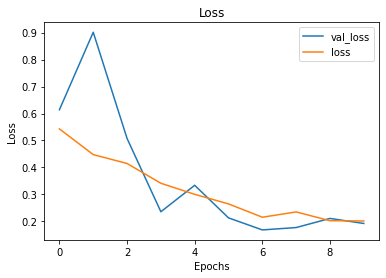

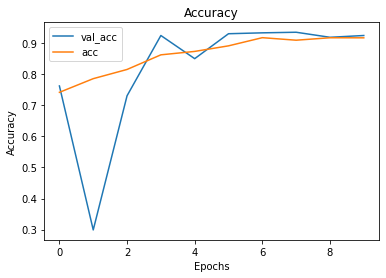

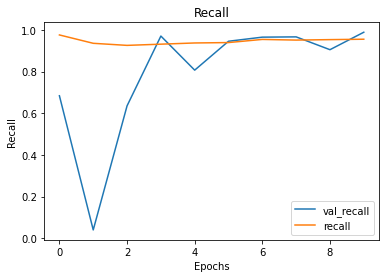

In [446]:
visualize_training_results(results_5)

In [447]:
results_train = model_5.evaluate(X_train, y_train)
results_test = model_5.evaluate(X_test, y_test)
print(results_train, results_test)

20/20 [==============================] - 2s 111ms/step - loss: 0.5345 - accuracy: 0.7660 - recall: 0.9923
[0.1860581636428833, 0.9268537163734436, 0.9891892075538635] [0.5344855785369873, 0.7660256624221802, 0.9923076629638672]


Similar to the above models: very overfit on the training data, but that accuracy is good.
Things to try moving forward:

- fix the class imbalance 
- construct a convoluted neural network, as those have been shown to preform best on image classification